## IGARSS Code Workshop

Ideas: data loading changes, bands, normalization, augmentation, batch size, loss functions, learning rate, decay, unfreeze/finetune

## Zurich Summer Data

In [45]:
# set up necessary dependencies
%matplotlib inline
!curl -s https://course.fast.ai/setup/colab | bash
!pip install -q --upgrade wandb rasterio imgaug==0.2.5

Updating fastai...
Done.


In [46]:
# mount our google drive to access data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [47]:
# optional login to Weights and Biases for metric tracking: https://www.wandb.com/
# !wandb login [APIKEY]

Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import os
import math
from functools import partial

from fastai.vision import *
import rasterio
import torch
from torch import nn
from torchvision.models import resnet34
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

import wandb
from wandb.fastai import WandbCallback

In [0]:
# convert our segmentation label colors to classes
classes =  {0:0, 125:1, 150:2, 230:3, 255:4, 300:5, 510:6, 555:7, 765:8}
class SatelliteSegmentationLabelList(SegmentationLabelList):
    def open(self, fn):
        with rasterio.open(fn) as src:
            return ImageSegment(torch.from_numpy(np.array([np.vectorize(classes.get)(np.sum(src.read(), axis=0))])).float())
    

In [0]:
# custom satellite segmentation class for reading our four band data
class SatelliteSegmentationItemList(SegmentationItemList):
    _label_cls = SatelliteSegmentationLabelList
    def open(self, fn):
        with rasterio.open(fn) as src:
            return Image(torch.from_numpy(src.read().astype(np.float32)).div_(torch.tensor([[[500.]], [[500.]], [[700.]], [[1000.]]])))
    def duplicate_items(self, n):
        to_dup = self.items
        self.items = np.repeat(to_dup, n)
        return self

In [0]:
# transform to provide random windowing into our large images
WINDOW_SIZE = (224, 224)
def _window_tfm(pxls, xrand:uniform=0.5, yrand:uniform=0.5):
    w, h = WINDOW_SIZE
    W, H = pxls.shape[-2:]
    x1 = math.floor(xrand * (W - w - 1))
    x2 = x1 + w
    y1 = math.floor(yrand * (H - h - 1))
    y2 = y1 + h
    return pxls[:, x1:x2,y1:y2]

window_tfm = TfmPixel(_window_tfm, order=1)
tfm = window_tfm(xrand=(0, 1), yrand=(0, 1))
xtra_tfms=[tfm]

In [0]:
# add extra transforms if desired
tfm_list = [
    window_tfm(xrand=(0, 1), yrand=(0, 1)),
#     zoom(scale=(1, 1.2)),
#     rotate(degrees=(-30, 30))
]

In [0]:
# create a fastai DataBunch with our imagery + labels + transforms + normalization
data = (SatelliteSegmentationItemList
  .from_folder('gdrive/My Drive/Zurich_dataset_v1.0/images_tif')
  .duplicate_items(6)
  .split_by_valid_func(lambda x: any([id in os.path.basename(x) for id in ['8', '9']]))
  .label_from_func(lambda x: f'gdrive/My Drive/Zurich_dataset_v1.0/groundtruth/{x.stem}_GT{x.suffix}', classes=list(range(len(classes))))
  .transform((tfm_list, tfm_list), tfm_y=True)
  .databunch(bs=16)
  .normalize()
      )

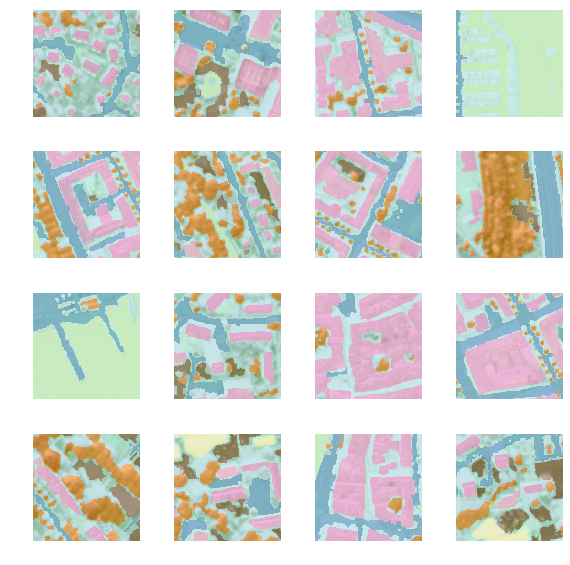

In [111]:
data.show_batch(figsize=(8,8))

In [0]:
def IOU(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [112]:
WEIGHT_DECAY=1e-2
wandb.init(project="igarss-zurich-test")
learner = unet_learner(data, resnet34, metrics=[IOU], wd=WEIGHT_DECAY, callback_fns=partial(WandbCallback, input_type='images'))

In [0]:
unet_input_conv = learner.model[0][0]
new_input = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
for i in range(3):
    new_input.weight[:,i] = unet_input_conv.weight[:,i]

for i in range(3,4):
    new_input.weight[:,i] = unet_input_conv.weight[:,2]

new_input.weight = nn.Parameter(new_input.weight.detach().requires_grad_(True))

learner.model[0][0] = new_input
learner.layer_groups[0][0] = learner.model[0][0]
learner.model[10][0][0] = nn.Conv2d(100, 100, kernel_size=(3,3), stride=(1,1), padding=(1,1))
learner.model[10][1][0] = nn.Conv2d(100, 100, kernel_size=(3,3), stride=(1,1), padding=(1,1))
learner.model[11][0] = nn.Conv2d(100, len(classes), kernel_size=(1,1), stride=(1,1))
if torch.cuda.is_available():
    learner.model.cuda()

In [0]:
learner.fit_one_cycle(30)

In [0]:
learner.show_results(rows=3)

In [0]:
learner.fit_one_cycle(30)

In [0]:
learner.show_results(rows=3)

In [0]:
# get the predictions on our validation set
preds, y_true = learner.get_preds()
pred_class = preds.argmax(dim=1)

In [0]:
# flatten our tensors and use scikit-learn to create a confusion matrix
flat_preds = pred_class.reshape(24 * 224 * 224)
flat_truth = y_true.reshape(24 * 224 * 224)
cm = confusion_matrix(flat_preds, flat_truth, labels=list(range(len(classes))))

In [0]:
class_labels = ['Roads', 'Buildings', 'Trees', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming pools', 'Background']  
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=class_labels, yticklabels=class_labels,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()